In [10]:
import pandas as pd
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
import dowhy
from dowhy import CausalModel

In [15]:
causal_graph = """
digraph {
Churn;
TotalCharges;
PaperlessBilling;
gender;
Partner
Contract;
StreamingMovies;
InternetService;
SeniorCitizen;
TechSupport;
TechSupport -> Churn; TotalCharges -> Churn; PaperlessBilling -> Churn;
gender -> TotalCharges; Partner -> TotalCharges; Contract -> TotalCharges;
Contract -> PaperlessBilling; 
StreamingMovies -> Contract; InternetService -> Contract; 
SeniorCitizen -> StreamingMovies; SeniorCitizen -> InternetService;SeniorCitizen -> TechSupport;
}


"""

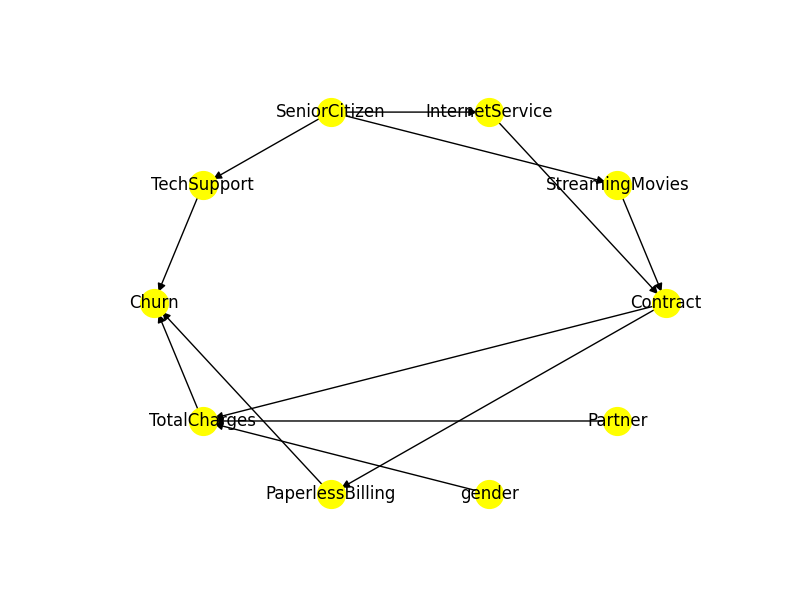

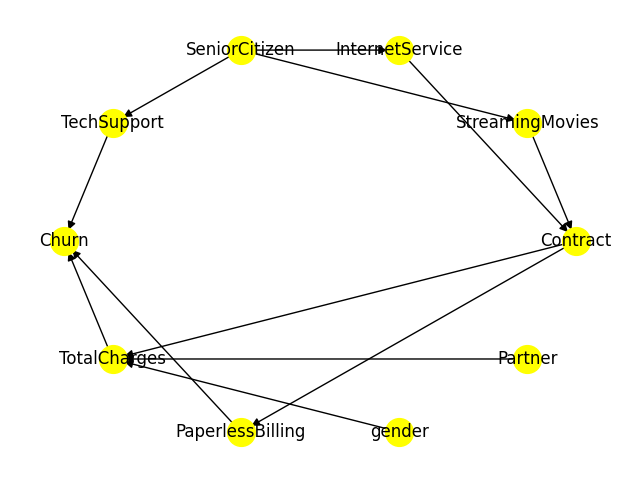

In [16]:
model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='TotalCharges',
        outcome='Churn')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [17]:
#Identify the causal effect
estimands = model.identify_effect()
print(estimands)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                          
───────────────(E[Churn|Contract])
d[TotalCharges]                   
Estimand assumption 1, Unconfoundedness: If U→{TotalCharges} and U→Churn then P(Churn|TotalCharges,Contract,U) = P(Churn|TotalCharges,Contract)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                              -1⎤
 ⎢        d                 ⎛        d                         ⎞  ⎥
E⎢──────────────────(Churn)⋅⎜──────────────────([TotalCharges])⎟  ⎥
 ⎣d[Partner  gender]        ⎝d[Partner  gender]                ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Churn then ¬(U →→{Partner,gender})
Estimand assumption 2, Exclusion: If we remove {Partner,gender}→{TotalCharges}, then ¬({Partner,gender}→Churn)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [18]:
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

ValueError: invalid literal for int() with base 10: '29.85'

In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
df.TotalCharges.value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [15]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [16]:
# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)

In [17]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

# III. Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")